In [1]:
# 변수의 shape, type, value 확인
def p(var,_name="") :
    if _name != "" : print(f'<<{_name}>>')
    if type(var)!=type([]):
        try:      print(f'Shape:{var.shape}')
        except :  pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}')

def pst(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}')

ref : https://www.tensorflow.org/text/tutorials/nmt_with_attention

# Neural machine translation with attention

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg"/>
  </td>
  <td>
   <img width=380 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The original from <a href=https://arxiv.org/abs/1508.04025v5>Effective Approaches to Attention-based Neural Machine Translation</a></th>
  <th colspan=1>This tutorial's model</th>
<tr>
</table>

commonly used in neural machine translation.

🔍 Key Concepts Visualized:
1. Encoder-Decoder Architecture
Left side (blue blocks): Encoder RNN processing the English input sequence: “I am a student”.

Right side (red blocks): Decoder RNN generating the French translation: “Je suis étudiant”.

2. Attention Mechanism
At each decoding step (e.g., generating “Je”), the decoder doesn't just rely on the last encoder hidden state.

Instead, it computes a context vector (light brown) that is a weighted sum of all encoder hidden states.

These attention weights (e.g., 0.5, 0.3, 0.1...) determine how much focus the decoder gives to each input word when generating the current output word.

3. Benefits of Attention
It helps the decoder focus on relevant parts of the input sentence during translation.

Especially important for long sentences, where a fixed-size context vector (as in vanilla seq2seq) would struggle.

📌 Example in the Image
When generating "Je", the decoder assigns the highest attention weight (0.5) to “I”.

This makes sense, as “Je” is the French equivalent of “I”.

## Setup

In [2]:
#%%capture
#!pip install "tensorflow-text>=2.11"
!pip install -U tensorflow-text==2.15.0

In [3]:
import numpy as np

import typing
from typing import Any, Tuple

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

tf.__version__,tf_text.__version__
#('2.15.1', '2.15.0')

('2.15.1', '2.15.0')

## The data

[Anki](http://www.manythings.org/anki/)에서 제공하는 언어 데이터 세트 사용  
언어 번역 쌍이 포함되어 있음  

### Download and prepare the dataset

1. 각 문장에 [START] 및 [END]토큰을 추가
2. 특수 문자 제거  
3. 단어 색인과 역방향 단어 색인 만들기
4. 각 문장을 최대 길이로 수정  

In [4]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
     origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
     extract=True)
path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'
path_to_file

2638744/2638744 [==============================] - 1s 0us/step


PosixPath('/root/.keras/datasets/spa-eng/spa.txt')

In [5]:
!ls {path_to_file}

/root/.keras/datasets/spa-eng/spa.txt


`\n`으로 문장이 분리되고, pair는 `\t`로 분리되어 는 있음 "eng"\t"spa"

In [6]:
text = path_to_file.read_text(encoding='utf-8')
print(f'text length:{len(text)}')
text[0]   # G
text[:10] # Go.\tVe.\nGo
text[:100] # Go.\tVe.\nGo.\tVete.\nGo.\tVaya.\nGo.\tVáyase.\nHi ....

text length:7919056


'Go.\tVe.\nGo.\tVete.\nGo.\tVaya.\nGo.\tVáyase.\nHi.\tHola.\nRun!\t¡Corre!\nRun.\tCorred.\nWho?\t¿Quién?\nFire!\t¡Fueg'

In [7]:
def load_data(path):
  text = path.read_text(encoding='utf-8')
  lines = text.splitlines()  # split(\n)
  pairs = [line.split('\t') for line in lines]
  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])
  return target, context

In [8]:
target_raw, context_raw = load_data(path_to_file)
p(target_raw[:],'target_raw')
p(context_raw[:],'context_raw')

<<target_raw>>
Shape:(118964,)
Type: <class 'numpy.ndarray'>
Values: ['Go.' 'Go.' 'Go.' ...
 'A carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities. Some people try to reduce their carbon footprint because they are concerned about climate change.'
 'Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Google and hope for something less irritating.'
 'If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.']
<<context_raw>>
Shape:(118964,)
Type: <class 'numpy.ndarray'>
Values: ['Ve.' 'Vete.' 'Vaya.' ...
 'Una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto 

### tf.data dataset 만들기

In [9]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

## 80%는 train data로 sampling
is_train = np.random.uniform(size=(len(target_raw),)) < 0.8
# is_train:[ True  True  True ... False  True  True]
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [10]:
for example_context_strings, example_target_strings in train_raw.take(1):
  p(example_context_strings[:5])
  print()
  p(example_target_strings[:5])
  break

Shape:(5,)
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Values: [b'Esto es demasiado importante para pasar por alto.'
 b'Ella debe ir all\xc3\xad.'
 b'A mi hijo le gustan los libros de animales.'
 b'Tom sali\xc3\xb3 a pescar poco antes del amanecer.'
 b'\xc2\xbfDe d\xc3\xb3nde has sacado esos zapatos tan raros?']

Shape:(5,)
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Values: [b'This is too important to overlook.' b'She must go there.'
 b'My son likes books about animals.'
 b'Tom left to go fishing shortly before dawn.'
 b'Where did you get those strange-looking shoes?']


### Text preprocessing

#### Text 표준화  
어휘가 제한된 다국어 모델을 구성하기 위해 입력 text를 표준화(Standardization)하여 사용하자  


1. unicode normalize operation(악센트 부호가 있는 문자를 분할하고 호환 문자를 해당 ASCII 문자로 대체)하고,  
2. 사용하지 않을 문자를 제거   


unicode normalize : http://unicode.org/reports/tr15/  
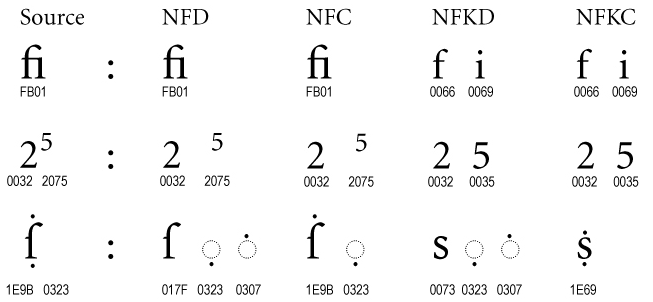

In [11]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
# b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())
# b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


Unicode normalization will be the first step in the text standardization function:

In [12]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')                       #'¿Todavía está en casa?'
  text = tf.strings.lower(text)                                     #'¿todavía está en casa?'
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')         #'¿todavia esta en casa?'
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')         #' ¿ todavia esta en casa ? '
  # Strip whitespace.
  text = tf.strings.strip(text)                                     #'¿ todavia esta en casa ?'
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ') #'[START] ¿ todavia esta en casa ? [END]'
  return text

In [13]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


#### Text Vectorization

`tf.keras.layers.TextVectorization` layer를 사용하여
1. 어휘 추출
2. Text를 token으로 변환  

Spanish `TextVectorization` layer

In [14]:
max_vocab_size = 5000
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

context_text_processor.adapt(train_raw.map(lambda context, target: context))
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

English  `TextVectorization` layer

In [15]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

`context_text_processor`: Strings을 token IDs로 변환

In [16]:
print('>>example_context_strings:',example_context_strings[:2])

example_tokens = context_text_processor(example_context_strings)
print('\n>>example_tokens:',example_tokens[:2])

>>example_context_strings: tf.Tensor(
[b'Esto es demasiado importante para pasar por alto.'
 b'Ella debe ir all\xc3\xad.'], shape=(2,), dtype=string)

>>example_tokens: <tf.RaggedTensor [[2, 58, 15, 123, 379, 31, 345, 21, 376, 4, 3],
 [2, 29, 284, 67, 190, 4, 3]]>


`get_vocabulary` method : token IDs를 text로 변환

In [17]:
context_vocab = np.array(context_text_processor.get_vocabulary())
# context_vocab:array(['', '[UNK]', '[START]', ...,'descubri'])
tokens = context_vocab[example_tokens[0].numpy()] # example_tokens[0]:EagerTensor
print('>>tokens:',tokens)
print('>>Join:',' '.join(tokens))

>>tokens: ['[START]' 'esto' 'es' 'demasiado' 'importante' 'para' 'pasar' 'por'
 'alto' '.' '[END]']
>>Join: [START] esto es demasiado importante para pasar por alto . [END]


token IDs에 zero-padding하여 고정길이로 만들고,  
뒷부분을 masking 하자  

In [18]:
p(example_tokens[:2]) # Ragged Tensor: 비정형(길이가 다른) Tensor
p(example_tokens[:2].to_tensor()) # 0추가로 길이를 맞춰 었음,

Shape:(2, None)
Type: <class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
Values: <tf.RaggedTensor [[2, 58, 15, 123, 379, 31, 345, 21, 376, 4, 3],
 [2, 29, 284, 67, 190, 4, 3]]>
Shape:(2, 11)
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Values: [[  2  58  15 123 379  31 345  21 376   4   3]
 [  2  29 284  67 190   4   3   0   0   0   0]]


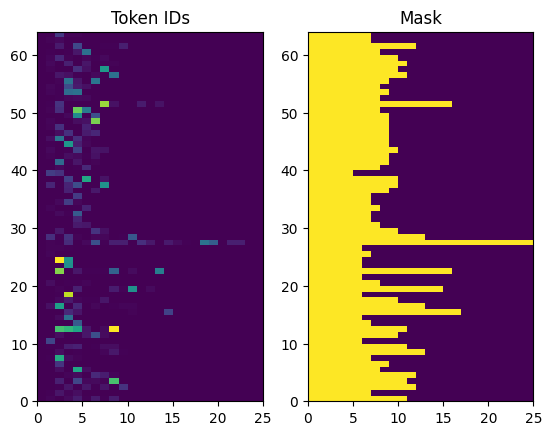

In [19]:
plt.subplot(1, 2, 1)
plt.title('Token IDs')
plt.pcolormesh(example_tokens.to_tensor())
plt.subplot(1, 2, 2)
plt.title('Mask')
plt.pcolormesh(example_tokens.to_tensor() != 0)

### Process the dataset



Context와 Target text를  
- 고정길이 tokens으로 바꾸고,  
- target은  
= target-in  : [0, ..., n-1]  
= target-out : [1,...,n]  을 생성하여,   
- (context, target-in), target-out) 쌍으로 반환하는  

Dataset: train_ds, val_ds를 생성    

In [20]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor() # token:[0,...,n-1]
  targ_out = target[:,1:].to_tensor() # token:[1,...,n]
  return (context, targ_in), targ_out

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

train_ds에서 첫번째 batch를 읽어 확인

In [21]:
context_vocab = np.array(context_text_processor.get_vocabulary())
target_vocab = np.array(target_text_processor.get_vocabulary())

for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print('>>ex_context_tok:',ex_context_tok[0, :10].numpy())
  print('>>ex_context_tok:',context_vocab[ex_context_tok[0,:20].numpy()])
  print('>>ex_tar_in:',ex_tar_in[0, :10].numpy())
  print('>>ex_tar_in:',target_vocab[ex_tar_in[0, :10].numpy()])
  print('>>ex_tar_out:',target_vocab[ex_tar_out[0, :10].numpy()])

>>ex_context_tok: [   2   20 1721   14   11  857    6   26 1573    4]
>>ex_context_tok: ['[START]' 'esta' 'prohibido' 'en' 'la' 'mayoria' 'de' 'los' 'paises' '.'
 '[END]' '' '' '' '' '' '']
>>ex_tar_in: [   2   50 1977   14  351 1535    4    0    0    0]
>>ex_tar_in: ['[START]' 'its' 'prohibited' 'in' 'most' 'countries' '.' '' '' '']
>>ex_tar_out: ['its' 'prohibited' 'in' 'most' 'countries' '.' '[END]' '' '' '']


## The encoder/decoder

인코더는 왼쪽에, 디코더는 오른쪽에,  
각 시간 단계에서 디코더의 출력은 인코더의 출력과 결합되어 다음 단어를 예측 함.


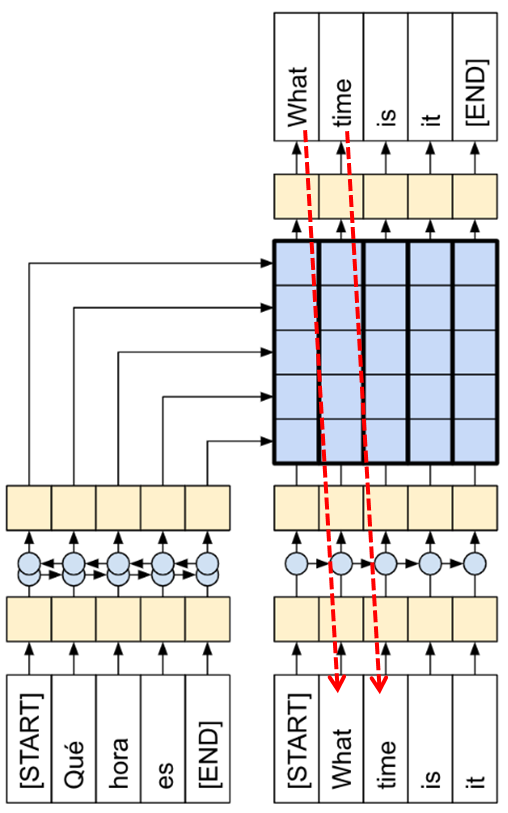

### The encoder

인코더의 목표는 컨텍스트 시퀀스를 디코더가 각 시간 단계에 대한 다음 출력을 예측하려고 시도할 때 유용한 벡터 시퀀스로 처리하는 것입니다. 컨텍스트 시퀀스가 ​​일정하기 때문에 인코더에서 정보가 흐르는 방식에 대한 제한이 없으므로 양방향 RNN을 사용하여 처리를 수행합니다.


1. `context_text_processor`에서 토큰 ID 목록을 가져 옴.
2. `layers.Embedding`을 사용, 각 토큰에 대한 임베딩 벡터를 찾고,  
3. `bidirectional GRU`를 사용, embedding vector 처리
4. 처리된 시퀀스를 반환, attention head로 전달


In [22]:
UNITS = 256

* Embedding layer

In [23]:
vocab_size = context_text_processor.vocabulary_size()
embedding = tf.keras.layers.Embedding(vocab_size, UNITS, mask_zero=True)
ps(ex_context_tok[:2],'ex_context_tok')
ps(embedding(ex_context_tok[:2]),'embedding(ex_context_tok)')
print('========')
embedding(ex_context_tok[0])

<<ex_context_tok>> Shape(2, 17)
<<embedding(ex_context_tok)>> Shape(2, 17, 256)


<tf.Tensor: shape=(17, 256), dtype=float32, numpy=
array([[ 0.01900102, -0.04767132, -0.01792217, ...,  0.00276114,
         0.00653566,  0.02527468],
       [-0.00396613, -0.03945206, -0.03024224, ..., -0.04139143,
         0.00063522, -0.04160989],
       [ 0.04992969,  0.0489063 , -0.02985315, ...,  0.03153047,
         0.03642795, -0.04285038],
       ...,
       [ 0.01420058, -0.04474007, -0.00070312, ..., -0.04098427,
         0.0478369 , -0.00166244],
       [ 0.01420058, -0.04474007, -0.00070312, ..., -0.04098427,
         0.0478369 , -0.00166244],
       [ 0.01420058, -0.04474007, -0.00070312, ..., -0.04098427,
         0.0478369 , -0.00166244]], dtype=float32)>

In [24]:
embedding(ex_context_tok[0][0])# 하나의 token -> 256dim vector

<tf.Tensor: shape=(256,), dtype=float32, numpy=
array([ 0.01900102, -0.04767132, -0.01792217,  0.04964986,  0.04263133,
       -0.01287395,  0.01078923,  0.03033723,  0.03219504,  0.03894827,
        0.00170747, -0.03957559,  0.02903916,  0.04961285,  0.03604983,
       -0.00854743, -0.00380667,  0.03106269, -0.00836967,  0.03353106,
        0.03890157,  0.02205474,  0.02989737,  0.0197338 ,  0.03130349,
        0.03090617,  0.026319  , -0.03651493,  0.00345008,  0.02865435,
        0.00150083, -0.01950985, -0.00117002, -0.01327066,  0.04278548,
        0.01743514,  0.00809032, -0.02522305,  0.00569578,  0.04420174,
        0.00625405, -0.02734683,  0.01231803,  0.00870198,  0.02704826,
        0.01507585, -0.02851801,  0.02917541, -0.02091719, -0.02756508,
        0.02293087, -0.00434058,  0.00011478,  0.03842703,  0.04985292,
       -0.00492446,  0.026219  ,  0.01546234,  0.00621001,  0.04735518,
        0.00727693,  0.01571775,  0.00175709,  0.02138957,  0.02980464,
       -0.016927

In [25]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(
            self.vocab_size, units, mask_zero=True)
    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(merge_mode='sum',
            layer=tf.keras.layers.GRU(units, return_sequences=True,
            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    # embedding vector <- each token.
    x = self.embedding(x)
    # GRU processes
    x = self.rnn(x)
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

Try it out:

In [26]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

ps(ex_context_tok) #(batch, s):(64,23)
ps(ex_context)     #(batch, s, units):(64,23,256)

<<>> Shape(64, 17)
<<>> Shape(64, 17, 256)


### The attention layer

Attention layer는  
- Decoder가 Encoder에서 추출한 정보에 접근하는 경로를 제공  
- Context seq.에서 vector를 계산하고,
- Decoder 출력에 추가함

전체 seq.에서 single vector를 계산하기 위해 시퀀스 전체에서 평균(layers.GlobalAveragePooling1D)을 얻음  
- Context seq.에서 가중 평균(weighted average)을 계산
- Weight : Context와 Query vector의 조합에서 계산됨  


In [27]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    attn_output, attn_scores = self.mha(
                  query=x,        #(bs, t, units)
                  value=context,  #(bs, s, units)
                  return_attention_scores=True)
    #(bs,t,s)<-(bs, heads, t, s)
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    self.last_attention_weights = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [28]:
# ((ex_context_tok, ex_tar_in), ex_tar_out) <- train_ds.take(1)
attention_layer = CrossAttention(UNITS)
# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in) #(64,16,256)<-(64,16)
result = attention_layer(ex_tar_embed, ex_context)#(64,16,256)<-((64,16,256),(64,16,256))

ps(ex_context)    #Context sequence(bs, s, units)  :(64, 16, 256) from Encoder
ps(ex_tar_embed)  #Target sequence(batch, t, units):(64, 16, 256)
ps(result)        #Attention result(bs, t, units)  :(64, 16, 256)
ps(attention_layer.last_attention_weights) #(batch, t, s):(64, 16, 16)

<<>> Shape(64, 17, 256)
<<>> Shape(64, 15, 256)
<<>> Shape(64, 15, 256)
<<>> Shape(64, 15, 17)


Target seq.의 각 시점에 대해서  
Context seq.(Encoder seq.)들의 attention weight를 sum 하면 '1'  
- softmax를 통해 확률로 표현 되었으므로 sum to 1

In [29]:
ps(attention_layer.last_attention_weights) #(batch, t, s):(64, 16, 16)
print(attention_layer.last_attention_weights[0].numpy().sum(axis=-1))

<<>> Shape(64, 15, 17)
[1.         0.99999994 1.         1.         1.         1.0000001
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]


**target seq.(`t=0`)**에 대한 context seq.의 attention weight를 확인하기 위해   
mask처리하여 시각화 해 보자  

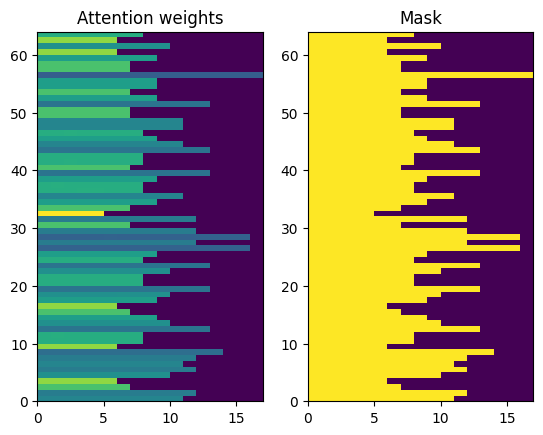

In [30]:
attention_weights = attention_layer.last_attention_weights #(bs,t,s):(64,16,16)
mask=(ex_context_tok != 0).numpy()                         #(bs,s):(64,16)

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])  #(bs,t=0,s):(64,16)
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

### The decoder

Decoder는 Target seq.의 각 시점에서 다음 token을 예측(생성)함  
1. Target seq.의 각 token에 대한 embedding결과를 얻어오고,  
2. RNN layer를 통해, target seq.를 처리하여 지금까지 생성한 내용을 추적함
3. RNN 출력을 Attention layer의 query값으로 넣어, Encoder의 출력에 attending하게 함
4. 각 시점에서의 출력은 다음 token의 예측임

훈련할 때 모델은 각 위치에서 다음 단어를 예측.  
따라서 정보가 모델을 통해 한 방향으로만 흐르도록 해야 함.  
따라서 Decoder는 target seq.처리를 위해 단방향(양방향이 아님)RNN을 사용함.  

추론을 실행할 때 한 시점에 하나의 단어를 생성하고,  
모델에 다시 피드백되어 입력으로 추가 됨.

Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [31]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')
    self.units = units
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.attention = CrossAttention(units)
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

call method:  
* context : Encoder 출력 context  
* x : target seq. input  
* statestate(option): RNN의 내부 상태. 텍스트 생성을 계속할 경우 사용할 마지막 상태  

In [32]:
@Decoder.add_method
def call(self, context, x, state=None, return_state=False):
  # x:(bs,t), context:(bs,s,units)
  x = self.embedding(x) #(bs,t,units)
  x, state = self.rnn(x, initial_state=state) # x:(bs,t,units)
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights #(bs,t,s)
  logits = self.output_layer(x) #(bs,t,target_vocab_size)

  if return_state: return logits, state
  else:            return logits

Decoder test

In training:  
* context와 target tokens이 주어지면, 다음 target token을 예측  

In [33]:
decoder = Decoder(target_text_processor, UNITS)
#(bs,t,target_vocab_size):(64,14,5000) <- (bs,s,units):(64,17,256),(bs,t):(64,14)
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, t, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 17, 256)
input target tokens shape: (batch, t) (64, 15)
logits shape shape: (batch, t, target_vocabulary_size) (64, 15, 5000)


#### Inference

추론을 위한 몇가기 methode 추가 하기

* encoder의 context를 넣고, start token

In [34]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)#fill(False)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0] # 0:LSTM일때(hidden,cell)중에서 hidden

In [35]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [36]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(  ##Decoder
    context, next_token,
    state = state,
    return_state=True)
  # logits:(bs,t,5000)
  if temperature == 0.0: # 무작위성 없음(greedy)
    next_token = tf.argmax(logits, axis=-1)
  else: # temperature로 무작위성을 높임(epsilon-greedy)
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)
  # `end_token`을 만나면, `done`<-1
  done = done | (next_token == self.end_token)
  # seq.에서 `done`을 만나면, next_token=`0` padding
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  return next_token, done, state

Test generation loop: 학습 전이므로 무작위 단어 배열

In [37]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []
for n in range(5):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)           #(n,64,1)
  print(f'n[{n}]:{decoder.tokens_to_text(tokens)[:,0].numpy()}')
# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1)   #(bs,t)<-(t,bs,1)
# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)#(bs,)
ps(result,'result') #(bs,)
print(result[:5])

n[0]:[b'nearly']
n[1]:[b'nearly' b'yours']
n[2]:[b'nearly' b'yours' b'boring']
n[3]:[b'nearly' b'yours' b'boring' b'insects']
n[4]:[b'nearly' b'yours' b'boring' b'insects' b'ufo']
<<result>> Shape(64,)
tf.Tensor(
[b'nearly yours boring insects ufo' b'mild picnics october attic attacked'
 b'fluent adjusted blanket nobody romans'
 b'produce hydrogen resist detail stolen'
 b'scare wage began birthday mood'], shape=(5,), dtype=string)


## Translator model

Training을 위한 Translator 만들기

In [38]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs              # x: target_in
    context = self.encoder(context)
    logits = self.decoder(context, x)
    return logits

Translator 입,출력 test  

In [39]:
model = Translator(UNITS, context_text_processor, target_text_processor)
logits = model((ex_context_tok, ex_tar_in))
# ex_context_tok(bs,s):(64, 20)
# ex_tar_in(bs,t):(64,20)
# logits(bs,t,target_voca_size):(64,20,5000)
print(f'Context tokens, shape: (batch, s) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s) (64, 17)
Target tokens, shape: (batch, t) (64, 15)
logits, shape: (batch, t, target_vocabulary_size) (64, 15, 5000)


### Train

각 문장의 길이가 다르므로, loss, accuracy계산시에 보정이 필요함  
* 의미 있는 부분만 남기고, 의미 있는 seq.길이로 나누어 보정  

In [40]:
def masked_loss(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)
    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [41]:
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [42]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

부분적인 evaluation을 통해 loss, acc값이 예측과 유사한지 확인 하기

In [43]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 8s 53ms/step - loss: 8.5255 - masked_acc: 9.2242e-05 - masked_loss: 8.5256


{'loss': 8.525517463684082,
 'masked_acc': 9.22424005693756e-05,
 'masked_loss': 8.525554656982422}

In [44]:
model.summary()

Model: "translator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  2069504   
                                                                 
 decoder_1 (Decoder)         multiple                  3223432   
                                                                 
Total params: 5292936 (20.19 MB)
Trainable params: 5292936 (20.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
%%time
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])
# Epoch 34/100 : Wall time: 6min 11s

Epoch 1/100
100/100 [==============================] - 24s 118ms/step - loss: 5.0452 - masked_acc: 0.2645 - masked_loss: 5.0457 - val_loss: 4.1349 - val_masked_acc: 0.3523 - val_masked_loss: 4.1365
Epoch 2/100
100/100 [==============================] - 10s 105ms/step - loss: 3.7259 - masked_acc: 0.4012 - masked_loss: 3.7280 - val_loss: 3.3588 - val_masked_acc: 0.4423 - val_masked_loss: 3.3587
Epoch 3/100
100/100 [==============================] - 10s 105ms/step - loss: 3.1272 - masked_acc: 0.4803 - masked_loss: 3.1300 - val_loss: 2.8457 - val_masked_acc: 0.5147 - val_masked_loss: 2.8496
Epoch 4/100
100/100 [==============================] - 11s 106ms/step - loss: 2.7145 - masked_acc: 0.5361 - masked_loss: 2.7170 - val_loss: 2.5034 - val_masked_acc: 0.5618 - val_masked_loss: 2.5040
Epoch 5/100
100/100 [==============================] - 11s 110ms/step - loss: 2.4234 - masked_acc: 0.5816 - masked_loss: 2.4252 - val_loss: 2.2766 - val_masked_acc: 0.5901 - val_masked_loss: 2.2762
Epoch 6/10

Wall time: 1min 16s


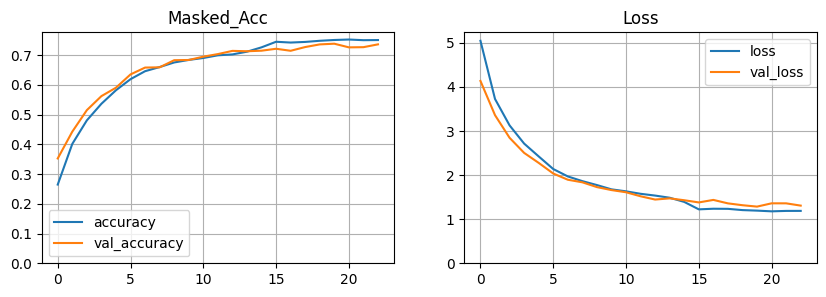

In [46]:
h1 = history.history
max_ = max(h1['val_masked_acc'])

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.title("Masked_Acc")
plt.plot(h1['masked_acc'], label='accuracy')
plt.plot(h1['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("Loss")
plt.plot(h1['loss'], label='loss')
plt.plot(h1['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
#plt.semilogy()
plt.legend()
plt.grid()
plt.show()

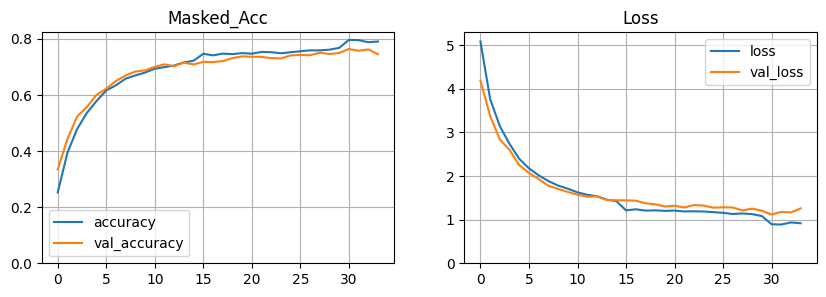

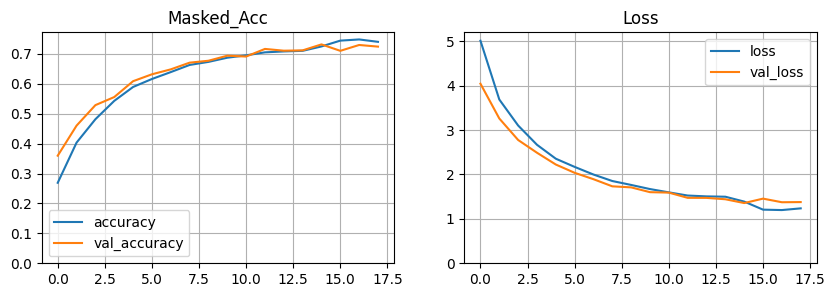

### Translate Method 추가

In [47]:
#@title
@Translator.add_method
def translate(self, texts, *, max_length=50, temperature=0.0):
  # Encoder: context<-RNN(context)
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]
  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)
  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    if tf.executing_eagerly() and tf.reduce_all(done):
      break # tf.reduce_all(done):done 모두 True?
  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # (bs,t)<-(t,bs,1)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # (bs,t,s)<-(t,bs,1,s)
  result = self.decoder.tokens_to_text(tokens)
  return result

Translator.translate() : 번역 실행 하기

In [48]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

'is he still at home ? '

Attention weight plot 하기

In [49]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()
  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]
  size_x = int(len(context)/2)
  size_y = int(len(output)/2)
  fig = plt.figure(figsize=(size_x, size_y))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 10}
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.show()

<ipython-input-49-2195016058>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-49-2195016058>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


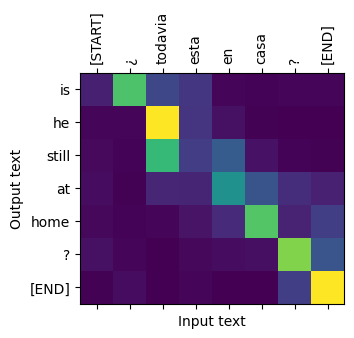

In [50]:
model.plot_attention('¿Todavía está en casa?') # Are you still home

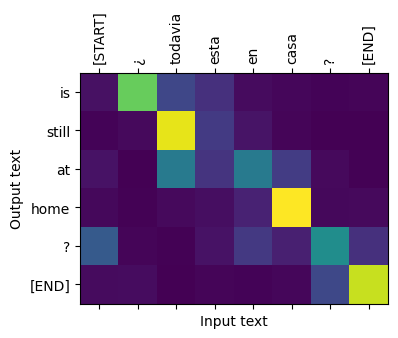

<ipython-input-49-2195016058>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-49-2195016058>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


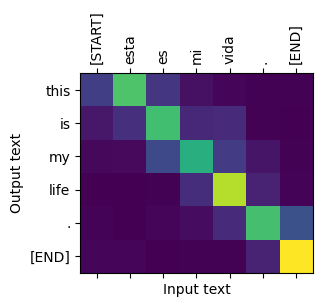

In [51]:
model.plot_attention('Esta es mi vida.') # This is my life.

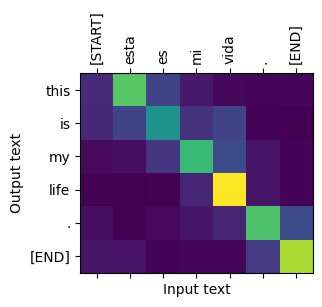

<ipython-input-49-2195016058>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-49-2195016058>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


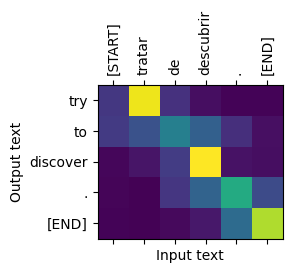

In [52]:
 # Try to find out.'
model.plot_attention('Tratar de descubrir.')

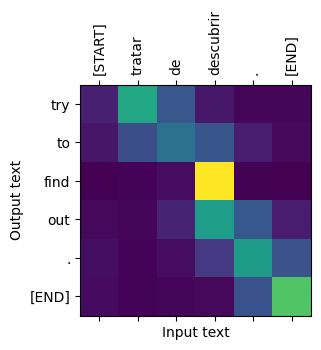

마지막 문장은 상대적으로 가장 긴 seq. 임  
- 긴 seq.에대한 처리 결과를 확인하자  

In [53]:
long_text = context_raw[-1]

print(f'Source context({len(context_raw[-1])})::{context_raw[-1]}')
print(f'Target text({len(target_raw[-1])})::{target_raw[-1]}')

Source context(264)::Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
Target text(247)::If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


<ipython-input-49-2195016058>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-49-2195016058>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


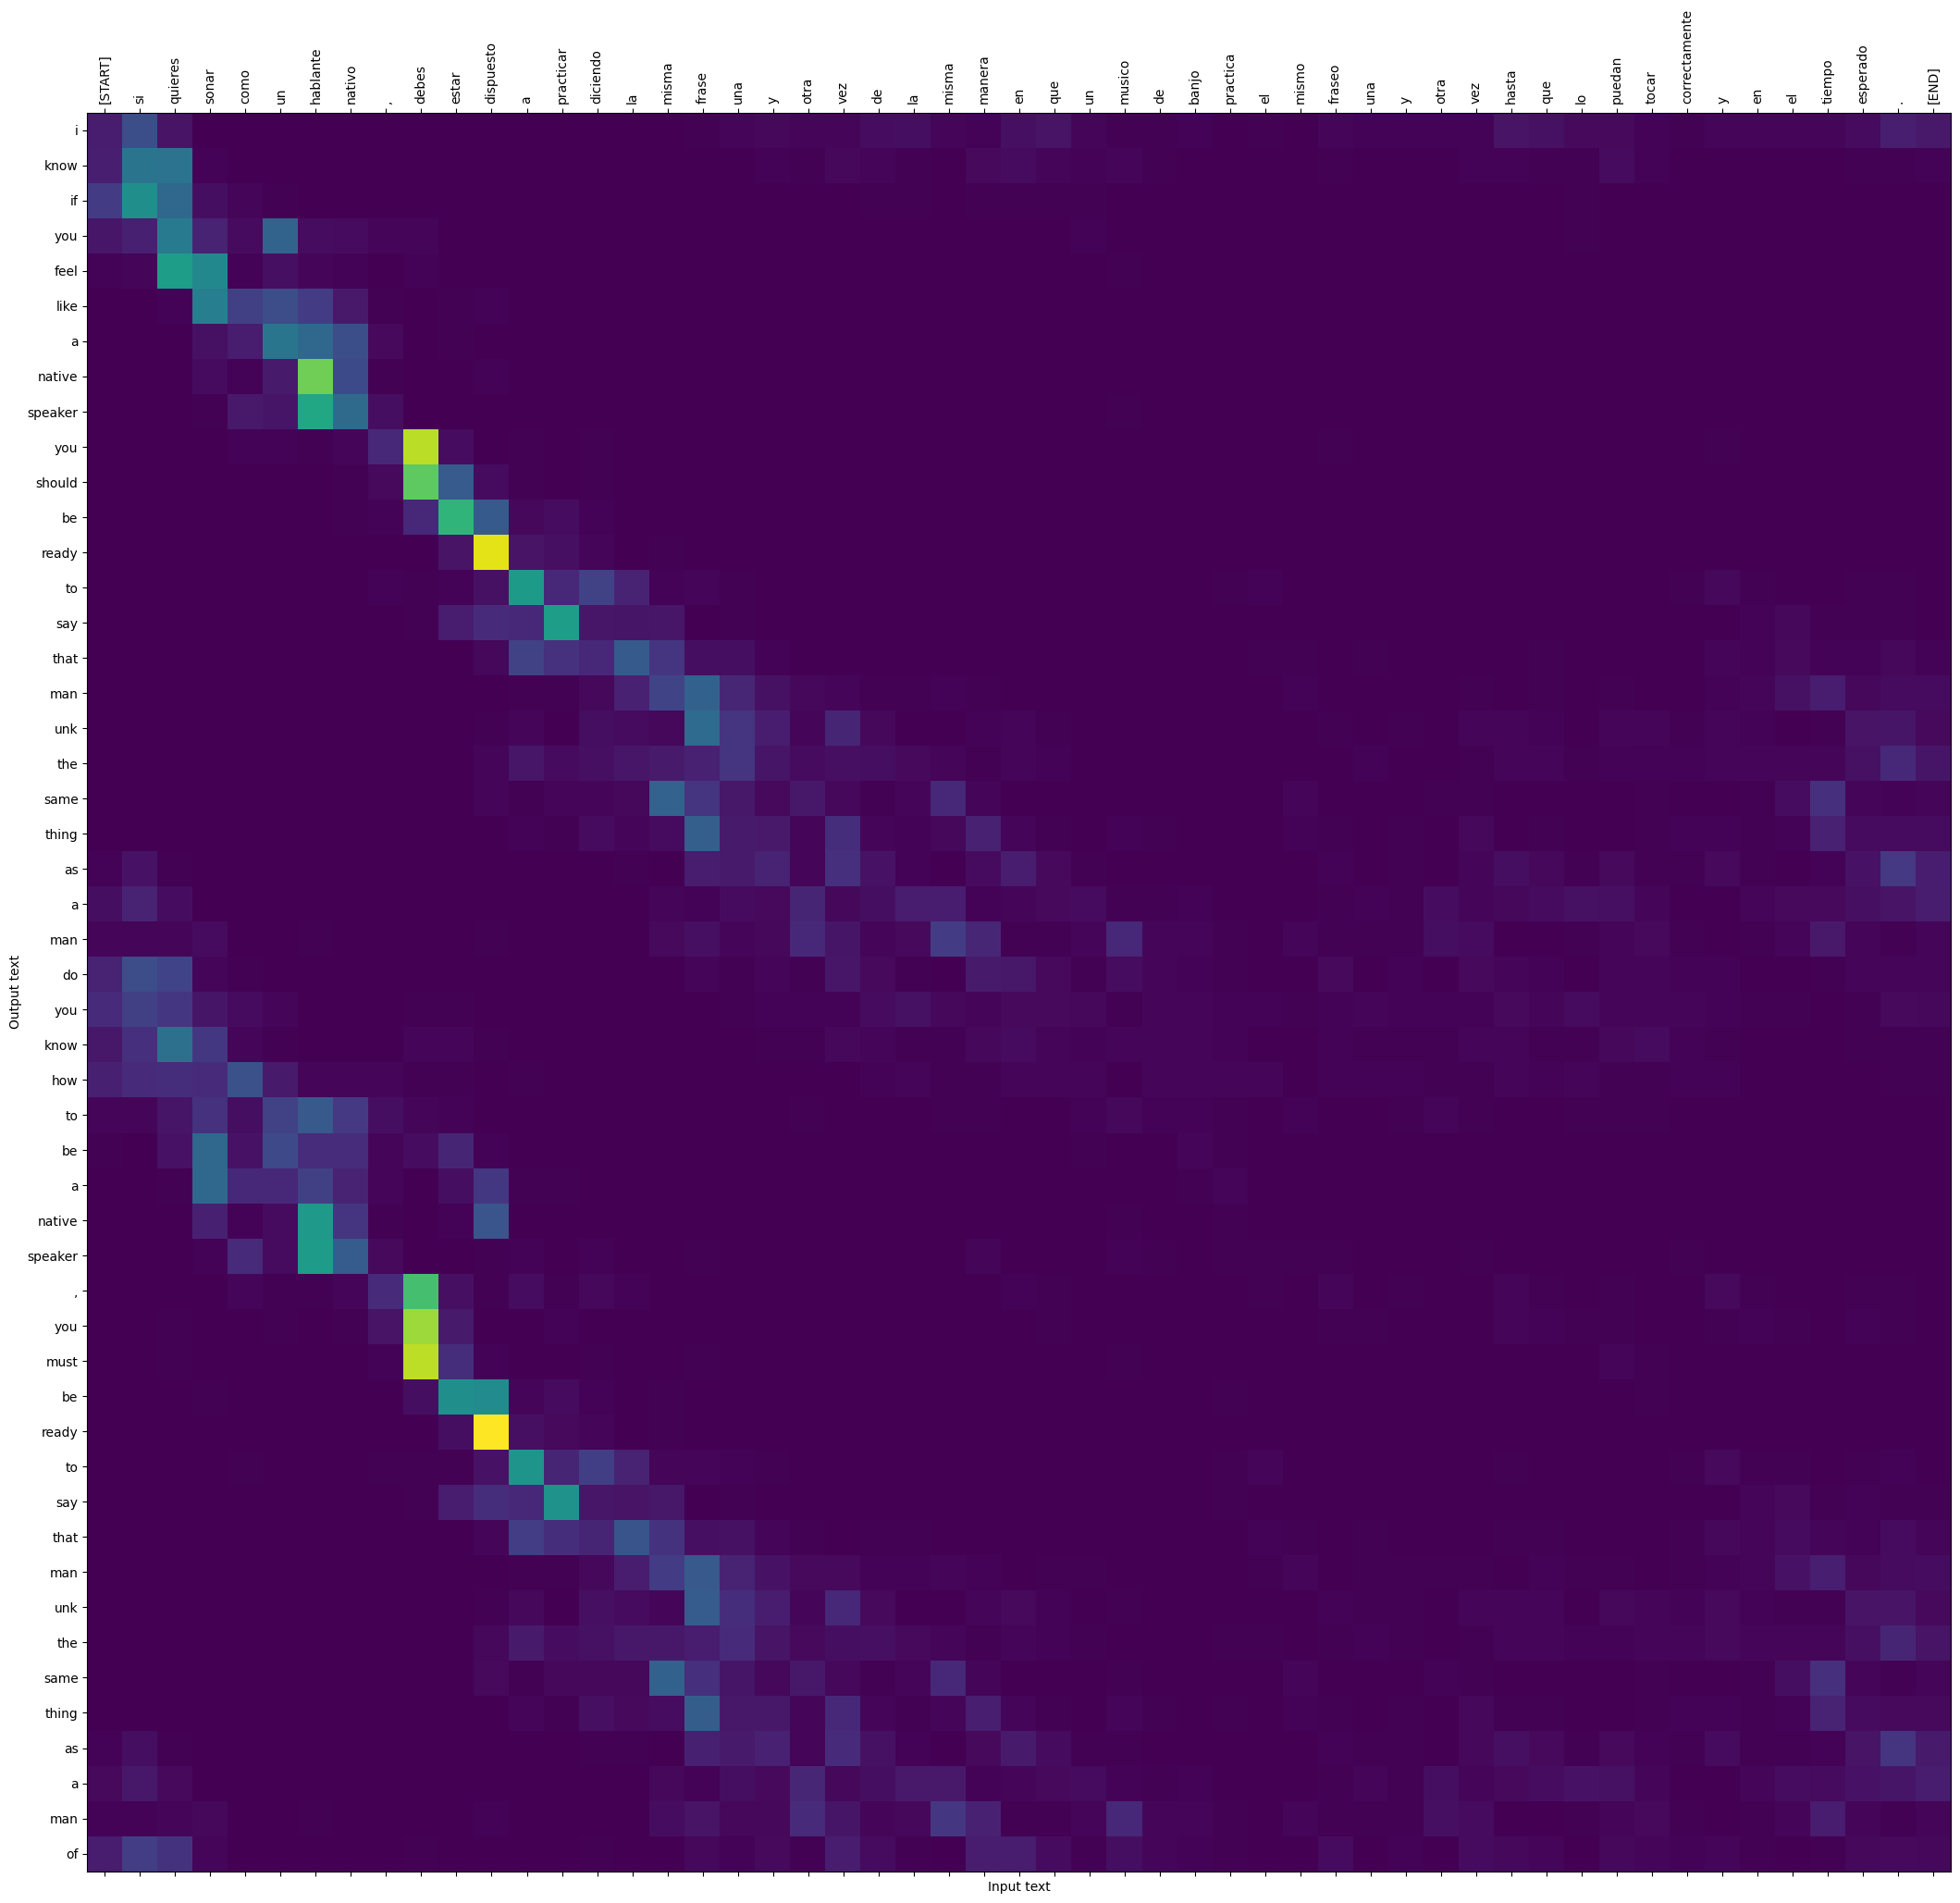

In [54]:
model.plot_attention(long_text)

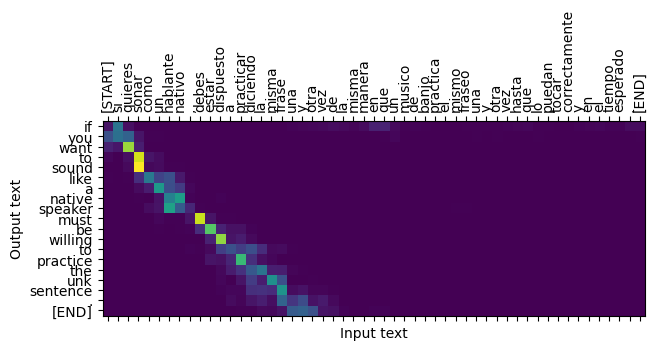

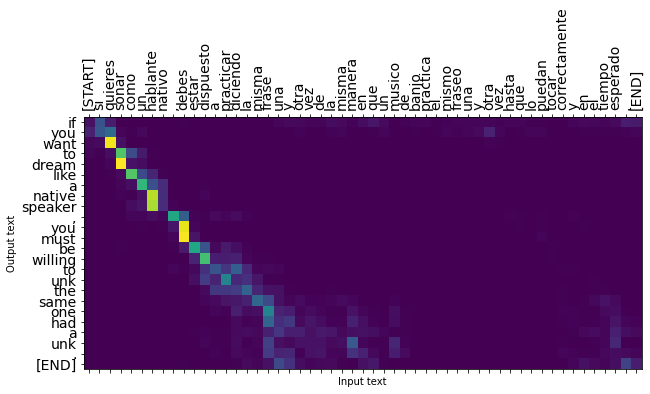